In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing libraries
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.metrics.distance import edit_distance
import string

# Feature extraction libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("All libraries imported successfully!")

All libraries imported successfully!


# Text Feature Engineering - BG3 Reviews Analysis

## Overview
This notebook demonstrates comprehensive text preprocessing and feature engineering techniques on the BG3 reviews dataset. We will convert unstructured text into meaningful numerical features suitable for machine learning analysis.

### Key Learning Objectives:
1. **Terminology**: Understand Corpus, Bag of Words, Document, Term, and Vocabulary
2. **Count Vectorizer**: Convert text documents to token count matrices
3. **TF-IDF Vectorizer**: Implement term frequency-inverse document frequency weighting
4. **Text Similarity**: Apply cosine similarity to compare documents
5. **Preprocessing Pipeline**: Implement comprehensive text cleaning and normalization

### Components to Cover:
- Tokenization by unigrams
- Case conversion to lowercase
- Remove punctuations
- Lemmatization
- Remove stop words
- Strip special characters and noises
- Remove spelling errors
- Expand contractions

In [2]:
# Load the dataset
df = pd.read_csv('bg3_reviews_train.csv')

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (33772, 3)

First few rows:
                                                text          date source
0  I cannot recommend this game enough. Larian ha...  Apr 21, 2025  steam
1  A game I can just sit and play for hours, ever...  Nov 25, 2025  steam
2  Great game hard to figure out the cam and thin...  May 02, 2025  steam
3  Apparently, I am playing this game of reviewin...  Nov 16, 2025  steam
4  Like the extensive story line, characters are ...  Nov 14, 2025  steam

Column names:
['text', 'date', 'source']

Data types:
text      str
date      str
source    str
dtype: object

Missing values:
text      0
date      0
source    0
dtype: int64


## Step 1: Data Preprocessing Pipeline

We will implement a comprehensive text preprocessing function that applies all cleaning techniques in the correct order:
1. Expand contractions (e.g., "don't" → "do not")
2. Convert to lowercase
3. Remove encoding artifacts (non-ASCII characters)
4. Remove URLs and special patterns
5. Tokenize into unigrams
6. Remove punctuation
7. Remove stop words
8. Lemmatize words
9. Remove spelling errors

In [3]:
# Dictionary for expanding common contractions
contractions_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have"
}

def expand_contractions(text):
    """
    Expand contractions in the text (e.g., don't -> do not)
    """
    pattern = re.compile(r'\b(' + '|'.join(contractions_dict.keys()) + r')\b')
    return pattern.sub(lambda x: contractions_dict[x.group()], text.lower())

# Test contraction expansion
test_text = "I can't believe it's not working. They've done it!"
print("Original:", test_text)
print("After contraction expansion:", expand_contractions(test_text))

Original: I can't believe it's not working. They've done it!
After contraction expansion: i cannot believe it is not working. they have done it!


In [4]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def simple_spell_check(word, dictionary):
    """
    Simple spell checking using edit distance
    Returns the closest word in dictionary if edit distance <= 1
    """
    if word in dictionary:
        return word
    
    # Find words with edit distance of 1
    candidates = [w for w in dictionary if edit_distance(word, w) == 1]
    
    if candidates:
        return candidates[0]
    return word

# Create a dictionary of common English words for spell checking
common_words = set(stopwords.words('english'))
# Add more vocabulary
common_words.update(['game', 'good', 'bad', 'love', 'hate', 'great', 'amazing', 
                     'beautiful', 'terrible', 'excellent', 'poor', 'wonderful'])

def preprocess_text(text):
    """
    Comprehensive text preprocessing pipeline
    
    Steps:
    1. Expand contractions
    2. Convert to lowercase (included in expand_contractions)
    3. Remove encoding artifacts (non-ASCII characters)
    4. Remove URLs and emails
    5. Remove special characters and extra whitespace
    6. Tokenize by unigrams
    7. Remove punctuation
    8. Remove stop words
    9. Lemmatization
    10. Simple spell correction
    
    Args:
        text (str): Raw text to preprocess
        
    Returns:
        list: List of cleaned and processed tokens
    """
    
    # Handle missing values
    if not isinstance(text, str):
        return ""
    
    # Step 1-2: Expand contractions and convert to lowercase
    text = expand_contractions(text)
    
    # Step 3: Remove encoding artifacts (mojibake from misencoded Unicode)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)  # Remove non-ASCII characters (mojibake from encoding issues)
    
    # Step 4: Remove URLs, emails, and mentions
    text = re.sub(r'http\S+|www\S+|[\w\.-]+@[\w\.-]+\.\w+|@\w+', ' ', text)
    
    # Step 5: Remove HTML tags and entities
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'&\w+;', ' ', text)
    
    # Step 6: Tokenize into unigrams (individual words)
    tokens = word_tokenize(text)
    
    # Step 7-8: Remove punctuation and stop words
    tokens = [token for token in tokens 
              if token not in string.punctuation 
              and token not in stop_words
              and len(token) > 1]  # Remove single characters
    
    # Step 9: Lemmatization
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]  # Lemmatize verbs
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # General lemmatization
    
    # Step 10: Simple spell correction (optional, for very misspelled words)
    # tokens = [simple_spell_check(token, common_words) for token in tokens]
        
    return tokens

# Test the preprocessing function
test_review = "I can't believe how amazing this game is! The graphics are absolutely stunning & the gameplay is very engaging. However, there r some bugs that need fixing. Don't worry, it's still the best RPG ever! #BG3 #DnD"
print("Original text:")
print(test_review)
print("\nCleaned text:")
print(preprocess_text(test_review))

Original text:
I can't believe how amazing this game is! The graphics are absolutely stunning & the gameplay is very engaging. However, there r some bugs that need fixing. Don't worry, it's still the best RPG ever! #BG3 #DnD

Cleaned text:


['believe', 'amaze', 'game', 'graphic', 'absolutely', 'stun', 'gameplay', 'engage', 'however', 'bug', 'need', 'fix', 'worry', 'still', 'best', 'rpg', 'ever', 'bg3', 'dnd']


## Step 2: Apply Preprocessing to 'text' Column

Now we apply the comprehensive preprocessing pipeline to the entire 'text' column in our dataset. This creates a cleaned version of the text that is ready for feature extraction and analysis.

In [5]:
# Create a copy of the dataframe with cleaned text
df_cleaned = df.copy()

# Apply preprocessing to the 'text' column
print("Processing text data... This may take a moment.")
df_cleaned['text_cleaned'] = df_cleaned['text'].apply(preprocess_text)

# Display sample results
print("\nSample preprocessing results:")
print("="*80)
for idx in range(min(3, len(df_cleaned))):
    print(f"\nExample {idx + 1}:")
    print(f"Original text:\n{df_cleaned['text'].iloc[idx][:200]}...")
    print(f"\nCleaned text:\n{df_cleaned['text_cleaned'].iloc[idx][:200]}...")
    print("-"*80)

# Check for empty cleaned texts
empty_texts = (df_cleaned['text_cleaned'] == '') | (df_cleaned['text_cleaned'].isnull())
print(f"\nTotal documents: {len(df_cleaned)}")
print(f"Empty cleaned texts: {empty_texts.sum()}")
print(f"Non-empty texts: {(~empty_texts).sum()}")

Processing text data... This may take a moment.



Sample preprocessing results:

Example 1:
Original text:
I cannot recommend this game enough. Larian has made a masterpiece that has surpassed all recent games over the last couple of decades, and will still shine above all others for decades to come. This ...

Cleaned text:
['recommend', 'game', 'enough', 'larian', 'make', 'masterpiece', 'surpass', 'recent', 'game', 'last', 'couple', 'decade', 'still', 'shine', 'others', 'decade', 'come', 'game', 'equivalent', 'lord', 'ring', 'trilogy', 'every', 'bite', 'praise', 'game', 'company', 'get', 'fully', 'deserve', 'let', 'know', 'game', 'undoubtedly', 'go', 'history', 'one', 'greatest', 'rpg', "'s", 'true', 'name', 'congratulation', 'everyone', 'work', 'game', 'truly', 'masterpiece', 'also', 'take', 'money', 'next', 'project']...
--------------------------------------------------------------------------------

Example 2:
Original text:
A game I can just sit and play for hours, every save is a different adventure....

Cleaned text:
['game',

In [6]:
# Save the cleaned dataset to a separate CSV file
output_path = 'bg3_reviews_train_cleaned.csv'
df_cleaned.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to: {output_path}")
print(f"Dataset shape: {df_cleaned.shape}")

Cleaned dataset saved to: bg3_reviews_train_cleaned.csv
Dataset shape: (33772, 4)


## Step 3: Count Vectorizer - Document-Term Matrix

### What is Count Vectorizer?
**Count Vectorizer** converts a collection of text documents into a matrix of token counts. Each row represents a document, and each column represents a unique word (term) in the vocabulary. The values in the matrix are the frequencies of each term in each document.

### Terminology:
- **Corpus**: Collection of all text documents
- **Document**: Individual text piece (review)
- **Term**: A word or n-gram
- **Vocabulary**: Complete list of unique terms in the corpus
- **Bag of Words (BoW)**: Representation that ignores word order but keeps frequency

### Key Parameters:
- `lowercase`: Convert all text to lowercase (default: True)
- `ngram_range`: Range for n-grams (1,1) = unigrams, (1,2) = unigrams + bigrams
- `stop_words`: Remove common words (already done in preprocessing)
- `max_features`: Limit vocabulary size to top N features by frequency

In [7]:
# Initialize Count Vectorizer with pre-tokenized input
cv = CountVectorizer(
    lowercase=False,        # already lowercase in preprocessing
    analyzer=lambda x: x,   # passthrough tokens
    ngram_range=(1, 1),     # Use unigrams only
    max_features=1000,      # Limit to top 1000 features
    min_df=2,               # Ignore terms that appear in less than 2 documents
    max_df=0.8              # Ignore terms that appear in more than 80% of documents
)

# Fit and transform the cleaned text data
cv_matrix = cv.fit_transform(df_cleaned['text_cleaned'])

# Get feature names (vocabulary)
feature_names = cv.get_feature_names_out()

print("Count Vectorizer Results:")
print("="*80)
print(f"Document-Term Matrix shape: {cv_matrix.shape}")
print(f"Number of documents: {cv_matrix.shape[0]}")
print(f"Number of unique terms (vocabulary size): {cv_matrix.shape[1]}")
print(f"\nVocabulary sample (first 20 terms):")
print(feature_names[:20])
print(f"\nVocabulary sample (random 20 terms):")
print(np.random.choice(feature_names, 20, replace=False))

Count Vectorizer Results:
Document-Term Matrix shape: (33772, 1000)
Number of documents: 33772
Number of unique terms (vocabulary size): 1000

Vocabulary sample (first 20 terms):
["''" "'s" '--' '..' '...' '....' '1.' '10' '10/10' '100' '11/10' '12'
 '15' '2.' '20' '200' '2023' '3.' '30' '300']

Vocabulary sample (random 20 terms):
['stick' 'beyond' 'felt' "'s" 'fire' 'forward' 'talk' 'lose' 'child'
 'group' 'appreciate' 'since' '30' 'bos' 'que' 'cause' 'wyll' 'worth'
 'game' 'type']


In [8]:
# Convert sparse matrix to dense array and create DataFrame for better visualization
cv_df = pd.DataFrame(
    cv_matrix.toarray(),
    columns=feature_names
)

print("\nCount Vectorizer Document-Term Matrix (sample):")
print(cv_df.iloc[:5, :10])  # First 5 documents, first 10 terms

# Analysis of term frequencies
print("\n\nTerm Frequency Analysis:")
print("="*80)
term_freq = cv_matrix.sum(axis=0).A1  # Sum frequencies across all documents
top_terms_idx = np.argsort(term_freq)[-20:][::-1]  # Top 20 terms
print("Top 20 most frequent terms:")
for i, idx in enumerate(top_terms_idx, 1):
    print(f"{i:2d}. {feature_names[idx]:20s} - Frequency: {int(term_freq[idx])}")

# Document statistics
doc_lengths = cv_matrix.sum(axis=1).A1  # Number of terms per document
print(f"\n\nDocument Statistics:")
print(f"Average terms per document: {doc_lengths.mean():.2f}")
print(f"Max terms in a document: {doc_lengths.max():.0f}")
print(f"Min terms in a document: {doc_lengths.min():.0f}")


Count Vectorizer Document-Term Matrix (sample):
   ''  's  --  ..  ...  ....  1.  10  10/10  100
0   0   1   0   0    0     0   0   0      0    0
1   0   0   0   0    0     0   0   0      0    0
2   0   0   0   0    0     0   0   0      0    0
3   0   0   0   0    0     0   0   0      0    0
4   0   0   0   0    0     0   0   0      0    0


Term Frequency Analysis:
Top 20 most frequent terms:
 1. game                 - Frequency: 63250
 2. play                 - Frequency: 22711
 3. like                 - Frequency: 11516
 4. character            - Frequency: 11006
 5. story                - Frequency: 10378
 6. make                 - Frequency: 10224
 7. time                 - Frequency: 9835
 8. one                  - Frequency: 9602
 9. get                  - Frequency: 9587
10. love                 - Frequency: 7685
11. best                 - Frequency: 7399
12. 's                   - Frequency: 7158
13. good                 - Frequency: 6823
14. hour                 - Frequency:

## Step 4: TF-IDF Vectorizer - Weighted Document-Term Matrix

### What is TF-IDF?
**TF-IDF** (Term Frequency-Inverse Document Frequency) assigns weights to terms based on their importance. It balances the frequency of a term in a document with its rarity across all documents.

### Formula Breakdown:
- **TF (Term Frequency)**: How often a term appears in a document / Total terms in document
- **IDF (Inverse Document Frequency)**: log(Total documents / Documents containing term)
- **TF-IDF**: TF × IDF

### Key Insight:
- **Rare words** (appear in few documents) → Higher IDF → Higher weight (more distinctive)
- **Common words** (appear in many documents) → Lower IDF → Lower weight (less informative)

This addresses limitations of Count Vectorizer where common words may dominate despite being less meaningful for document analysis.

### Scikit-learn TF-IDF Implementation:
- Uses **natural logarithm (ln)** for IDF calculation
- Normalizes resulting TF-IDF vectors using **Euclidean norm**

In [9]:
# Initialize TF-IDF Vectorizer with unigrams
tfidf = TfidfVectorizer(
    lowercase=False,        # already lowercase in preprocessing
    analyzer=lambda x: x,   # passthrough tokens
    ngram_range=(1, 1),
    max_features=1000,
    min_df=2,
    max_df=0.8,
    norm='l2',
    sublinear_tf=False
)

# Fit and transform the cleaned text data
tfidf_matrix = tfidf.fit_transform(df_cleaned['text_cleaned'])

# Get feature names (vocabulary)
tfidf_feature_names = tfidf.get_feature_names_out()

print("TF-IDF Vectorizer Results:")
print("="*80)
print(f"Document-Term Matrix shape: {tfidf_matrix.shape}")
print(f"Number of documents: {tfidf_matrix.shape[0]}")
print(f"Number of unique terms: {tfidf_matrix.shape[1]}")
print(f"Sparsity: {(1.0 - tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100:.2f}%")

TF-IDF Vectorizer Results:
Document-Term Matrix shape: (33772, 1000)
Number of documents: 33772
Number of unique terms: 1000
Sparsity: 97.76%


In [10]:
# Convert sparse matrix to DataFrame for better visualization
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf_feature_names
)

print("\nTF-IDF Document-Term Matrix (sample):")
print(tfidf_df.iloc[:5, :10])  # First 5 documents, first 10 terms

# Analyze TF-IDF weights
print("\n\nTF-IDF Weight Analysis:")
print("="*80)
tfidf_weights = tfidf_matrix.sum(axis=0).A1
top_weighted_idx = np.argsort(tfidf_weights)[-20:][::-1]

print("Top 20 terms by TF-IDF weight:")
for i, idx in enumerate(top_weighted_idx, 1):
    print(f"{i:2d}. {tfidf_feature_names[idx]:20s} - Total TF-IDF: {tfidf_weights[idx]:.4f}")

# Compare top terms in Count vs TF-IDF
print("\n\nComparison: Count Vectorizer vs TF-IDF")
print("="*80)
count_top_20 = set([feature_names[i] for i in np.argsort(term_freq)[-20:][::-1]])
tfidf_top_20 = set([tfidf_feature_names[i] for i in np.argsort(tfidf_weights)[-20:][::-1]])
common = count_top_20.intersection(tfidf_top_20)

print(f"Count Vectorizer top 20 terms: {sorted(count_top_20)}")
print(f"\nTF-IDF top 20 terms: {sorted(tfidf_top_20)}")
print(f"\nTerms appearing in both lists: {len(common)} out of 20")
print(f"Common terms: {sorted(common)}")


TF-IDF Document-Term Matrix (sample):
    ''        's   --   ..  ...  ....   1.   10  10/10  100
0  0.0  0.101806  0.0  0.0  0.0   0.0  0.0  0.0    0.0  0.0
1  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0    0.0  0.0
2  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0    0.0  0.0
3  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0    0.0  0.0
4  0.0  0.000000  0.0  0.0  0.0   0.0  0.0  0.0    0.0  0.0


TF-IDF Weight Analysis:
Top 20 terms by TF-IDF weight:
 1. game                 - Total TF-IDF: 3545.9037
 2. play                 - Total TF-IDF: 1989.9317
 3. best                 - Total TF-IDF: 1123.4742
 4. like                 - Total TF-IDF: 1079.1001
 5. one                  - Total TF-IDF: 1065.4694
 6. time                 - Total TF-IDF: 1035.0493
 7. story                - Total TF-IDF: 1011.8312
 8. make                 - Total TF-IDF: 988.4537
 9. love                 - Total TF-IDF: 976.8068
10. get                  - Total TF-IDF: 975.5816
11. character            - Total TF-I

## Step 5: Text Similarity - Cosine Similarity

### What is Text Similarity?
Text similarity measures how alike two documents are. It's fundamental for:
- Information retrieval (finding related documents)
- Document clustering (grouping similar reviews)
- Topic modeling
- Recommendation systems

### Cosine Similarity
**Cosine Similarity** measures the angle between two document vectors in the vector space.

#### Key Properties:
- Range: **-1 to 1** (typically 0 to 1 for normalized vectors)
- **1.0**: Documents are identical (same direction)
- **0.0**: Documents are completely different (perpendicular)
- **-1.0**: Documents are opposite (rare for text)

#### Why Cosine Similarity for Text?
- Focuses on **word overlap**, ignoring document length
- Ignores zero values (sparse matrices)
- Computationally efficient
- Interpretable results (0-1 for text)

#### Interpretation:
- Similarity > 0.7: Documents are highly similar
- Similarity 0.3-0.7: Documents have some similarities
- Similarity < 0.3: Documents are quite different

In [11]:
# Calculate cosine similarity matrix on full dataset
# Using TF-IDF vectors for better semantic representation
print("Calculating cosine similarity matrix...")
print("This may take a moment for larger datasets...")

# For computational efficiency, we'll use a subset of documents
# (Full dataset can create very large matrices)
sample_size = min(100, len(df_cleaned))  # Use up to 100 documents
sample_indices = np.random.choice(len(df_cleaned), sample_size, replace=False)
tfidf_sample = tfidf_matrix[sample_indices]

# Calculate cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_sample)

print(f"\nCosine Similarity Matrix shape: {cosine_sim_matrix.shape}")
print(f"Analyzing {sample_size} sample documents")

# Analyze similarity statistics
print("\n\nSimilarity Statistics:")
print("="*80)
# Get upper triangle (avoid duplicates and diagonal)
upper_triangle = cosine_sim_matrix[np.triu_indices_from(cosine_sim_matrix, k=1)]

print(f"Mean similarity: {upper_triangle.mean():.4f}")
print(f"Median similarity: {np.median(upper_triangle):.4f}")
print(f"Min similarity: {upper_triangle.min():.4f}")
print(f"Max similarity: {upper_triangle.max():.4f}")
print(f"Std deviation: {upper_triangle.std():.4f}")

# Identify most similar documents
print("\n\nMost Similar Document Pairs (Top 10):")
print("="*80)
# Find indices of highest similarities (excluding diagonal)
flat_indices = np.argsort(cosine_sim_matrix.flatten())[::-1]
count = 0
for flat_idx in flat_indices:
    if count >= 10:
        break
    i, j = np.unravel_index(flat_idx, cosine_sim_matrix.shape)
    if i != j and i < j:  # Avoid diagonal and duplicates
        print(f"Document {sample_indices[i]} - Document {sample_indices[j]}: {cosine_sim_matrix[i, j]:.4f}")
        count += 1

Calculating cosine similarity matrix...
This may take a moment for larger datasets...

Cosine Similarity Matrix shape: (100, 100)
Analyzing 100 sample documents


Similarity Statistics:
Mean similarity: 0.0472
Median similarity: 0.0292
Min similarity: 0.0000
Max similarity: 0.5942
Std deviation: 0.0552


Most Similar Document Pairs (Top 10):
Document 7164 - Document 3548: 0.5942
Document 31984 - Document 20550: 0.4454
Document 21858 - Document 3208: 0.4336
Document 31084 - Document 3548: 0.4306
Document 4927 - Document 17820: 0.4212
Document 7164 - Document 18638: 0.3486
Document 4927 - Document 15591: 0.3444
Document 5982 - Document 13339: 0.3290
Document 19516 - Document 27392: 0.3243
Document 24919 - Document 32483: 0.3221


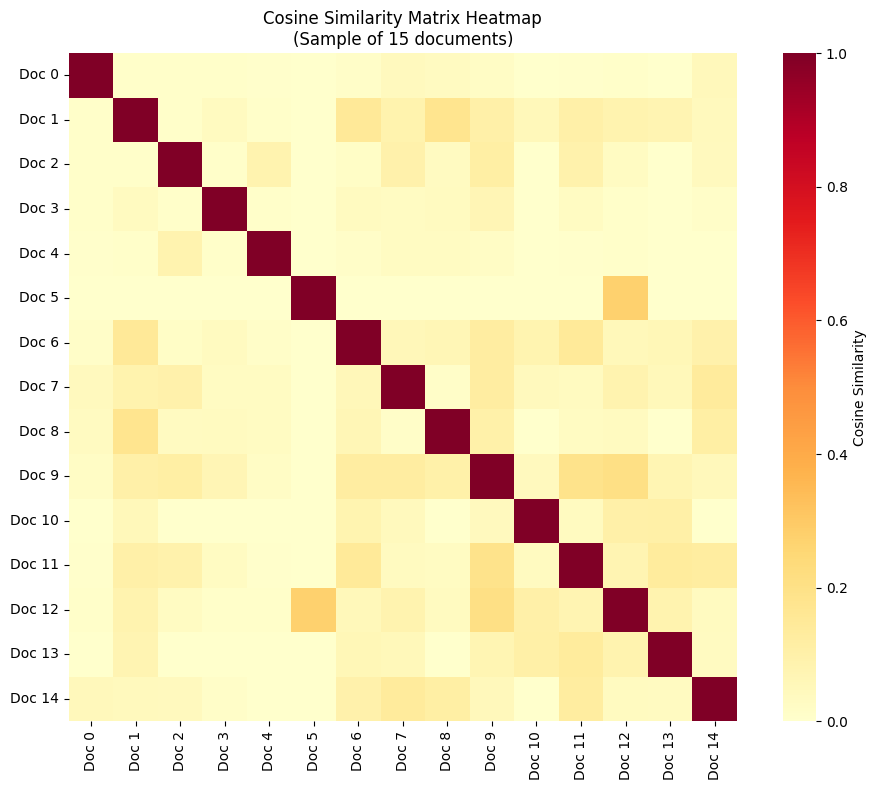

Heatmap generated successfully!


In [12]:
# Visualize similarity matrix as heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Create a smaller sample for visualization (15 documents)
viz_size = min(15, sample_size)
viz_indices = sample_indices[:viz_size]
cosine_sim_viz = cosine_sim_matrix[:viz_size, :viz_size]

plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_viz, 
            cmap='YlOrRd', 
            square=True, 
            cbar_kws={'label': 'Cosine Similarity'},
            xticklabels=[f'Doc {i}' for i in range(viz_size)],
            yticklabels=[f'Doc {i}' for i in range(viz_size)])
plt.title('Cosine Similarity Matrix Heatmap\n(Sample of 15 documents)')
plt.tight_layout()
plt.show()

print("Heatmap generated successfully!")

## Findings: Cosine Similarity Heatmap

A cosine similarity matrix was visualized using a **sample of 15 documents** to examine pairwise textual similarity between reviews.

### Interpretation
- Each cell in the heatmap represents the **cosine similarity** between two documents.
- Warmer colors (yellow/red) indicate **higher similarity**, while cooler colors indicate **lower similarity**.
- The diagonal shows a similarity of **1.0**, as each document is perfectly similar to itself.

### Observations
- Most off-diagonal values show **moderate to low similarity**, suggesting that the sampled reviews are generally distinct in content.
- A few localized regions of higher similarity indicate **clusters of reviews with overlapping themes or language**, potentially reflecting similar feedback topics.
- The absence of large high-similarity blocks suggests there is **no excessive duplication** within the sampled reviews.

### Implications
- The dataset exhibits **meaningful diversity in textual content**, which is suitable for downstream tasks such as classification or clustering.
- Observed similarity clusters may correspond to shared discussion points (e.g., gameplay mechanics, narrative elements).


## Step 6: Scikit-Learn Pairwise Metrics

### What are Pairwise Metrics?
Pairwise metrics compute distances or similarities between all pairs of samples in a dataset. Scikit-learn's `pairwise_distances` function provides multiple distance metrics for comprehensive comparison.

### Available Distance Metrics:
- **Euclidean**: Straight-line distance (good for continuous features)
- **Manhattan**: Sum of absolute differences (robust to outliers)
- **Cosine**: Angular distance (already covered)
- **Hamming**: Number of differing positions (for categorical)
- **Jaccard**: (|A∩B|) / (|A∪B|) - overlap ratio

### Use Cases:
- Finding nearest neighbors for recommendations
- Clustering documents based on similarity
- Anomaly detection
- Document retrieval systems

In [13]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, euclidean_distances

# Calculate pairwise distances using different metrics
print("Calculating Pairwise Metrics...")
print("="*80)

# Use a smaller sample for computation efficiency
pairwise_sample_size = min(50, len(df_cleaned))
pairwise_indices = np.random.choice(len(df_cleaned), pairwise_sample_size, replace=False)
tfidf_pairwise = tfidf_matrix[pairwise_indices]

# Cosine distance (1 - cosine similarity)
cosine_dist = cosine_distances(tfidf_pairwise)

# Euclidean distance
euclidean_dist = euclidean_distances(tfidf_pairwise)

print(f"Cosine Distance Matrix shape: {cosine_dist.shape}")
print(f"Euclidean Distance Matrix shape: {euclidean_dist.shape}")

# Analyze distances
print("\n\nCosine Distance Statistics:")
print("-"*80)
upper_cosine = cosine_dist[np.triu_indices_from(cosine_dist, k=1)]
print(f"Mean cosine distance: {upper_cosine.mean():.4f}")
print(f"Median cosine distance: {np.median(upper_cosine):.4f}")
print(f"Min distance: {upper_cosine.min():.4f}")
print(f"Max distance: {upper_cosine.max():.4f}")

print("\n\nEuclidean Distance Statistics:")
print("-"*80)
upper_euclidean = euclidean_dist[np.triu_indices_from(euclidean_dist, k=1)]
print(f"Mean euclidean distance: {upper_euclidean.mean():.4f}")
print(f"Median euclidean distance: {np.median(upper_euclidean):.4f}")
print(f"Min distance: {upper_euclidean.min():.4f}")
print(f"Max distance: {upper_euclidean.max():.4f}")

Calculating Pairwise Metrics...
Cosine Distance Matrix shape: (50, 50)
Euclidean Distance Matrix shape: (50, 50)


Cosine Distance Statistics:
--------------------------------------------------------------------------------
Mean cosine distance: 0.9562
Median cosine distance: 0.9741
Min distance: 0.6115
Max distance: 1.0000


Euclidean Distance Statistics:
--------------------------------------------------------------------------------
Mean euclidean distance: 1.3824
Median euclidean distance: 1.3958
Min distance: 1.1059
Max distance: 1.4142


In [14]:
# Find nearest neighbors for specific documents
print("\n\nFinding Nearest Neighbors (k=5):")
print("="*80)

def find_nearest_neighbors(distance_matrix, doc_idx, k=5):
    """Find k nearest neighbors for a given document"""
    distances = distance_matrix[doc_idx]
    nearest_indices = np.argsort(distances)[1:k+1]  # Exclude self (index 0)
    nearest_distances = distances[nearest_indices]
    return nearest_indices, nearest_distances

# Select a random document and find its neighbors
test_doc_idx = 0
print(f"\nDocument {pairwise_indices[test_doc_idx]}:")
print(f"Original text: {df_cleaned['text'].iloc[pairwise_indices[test_doc_idx]][:150]}...")
print(f"Cleaned text: {df_cleaned['text_cleaned'].iloc[pairwise_indices[test_doc_idx]]}")

print(f"\n5 Nearest Neighbors (by cosine distance):")
neighbors_cosine, distances_cosine = find_nearest_neighbors(cosine_dist, test_doc_idx, k=5)
for i, (neighbor_idx, distance) in enumerate(zip(neighbors_cosine, distances_cosine), 1):
    actual_idx = pairwise_indices[neighbor_idx]
    similarity = 1 - distance  # Convert distance to similarity
    print(f"\n  {i}. Document {actual_idx} (Similarity: {similarity:.4f})")
    print(f"     Text: {df_cleaned['text'].iloc[actual_idx][:120]}...")



Finding Nearest Neighbors (k=5):

Document 16834:
Original text: The best game made to date. I recommend everyone to give it a try, even if you are not familiar with the genre....
Cleaned text: ['best', 'game', 'make', 'date', 'recommend', 'everyone', 'give', 'try', 'even', 'familiar', 'genre']

5 Nearest Neighbors (by cosine distance):

  1. Document 4508 (Similarity: 0.1279)
     Text: best game in my long ass korean gamer life, even BEST OF BEST as my lesbian korean gamer ass. as millenial korean i grew...

  2. Document 21741 (Similarity: 0.1198)
     Text: The best game I've played in recent memory. Highly recommend if you enjoy good rpgs or DND...

  3. Document 3617 (Similarity: 0.1140)
     Text: Great game!! Actually my first RPG (or video game outside Mario Kart) ever! I keep playing as the options never end. 10/...

  4. Document 27329 (Similarity: 0.1051)
     Text: I never was into the whole fantasy genre, i liked to play my pen & papers in a realistic setting, but this 

### Step 7: Labelling (target creation) assign 'Engineering', 'Design', or 'Narrative' based on keywords. Uses priority logic: Engineering > Design > Narrative

In [15]:
# ==========================================
# 1. ENGINEERING (Technical Failures)
# ==========================================
eng_keywords = [
    # Core Terms
    'crash', 'bug', 'lag', 'freeze', 'error', 'glitch', 'performance', 'fps', 'optimize',
    'stutter', 'latency', 'disconnect', 'server', 'connection', 'ping', 'broken',
    'launch', 'startup', 'boot', 'screen', 'monitor', 'gpu', 'cpu', 'hardware',
    'save', 'corrupt', 'loading', 'install', 'update', 'patch', 'driver', 'softlock',
    
    # Specific Tech Jargon (Added)
    'framerate', 'drop', 'spikes', 'rubberband', 'packet', 'loss', 'netcode',
    'desktop', 'bsod', 'freezing', 'optimization', 'rendering', 'texture', 'pop-in',
    
    # UK Spellings & Common Typos (The "Safety Net")
    'optimise', 'optimisation', 'color', 'colour', # UK/US
    'unplayable', 'crashs', 'crashing', 'crashed', # Lemma misses some irregulars
    'laggy', 'lagg', 'glitchy', 'buggy',
    'fps', 'framerates', 'stuttering', 'disconnects'
]

# ==========================================
# 2. DESIGN (Gameplay & Mechanics)
# ==========================================
design_keywords = [
    # Core Terms
    'mechanic', 'gameplay', 'combat', 'level', 'balance', 'ui', 'difficulty', 'grind',
    'control', 'camera', 'system', 'class', 'skill', 'ability', 'loot', 'reward',
    'economy', 'pacing', 'progression', 'enemy', 'boss', 'ai', 'inventory', 'map',
    'mission', 'objective', 'tutorial', 'accessibility', 'clunky', 'repetitive',
    
    # Specific Design Jargon (Added)
    'nerf', 'buff', 'op', 'overpowered', 'underpowered', 'hitbox', 'physics',
    'hud', 'menu', 'interface', 'navigation', 'paywall', 'microtransaction', 'p2w',
    'shop', 'store', 'unlock', 'crafting', 'perk', 'talent', 'stat', 'stats',
    
    # Typos & Variations
    'balence', 'lvl', 'lvls', 'quests', 'questing', 'difficult', 'boring',
    'controls', 'handling', 'movement', 'enemies'
]

# ==========================================
# 3. NARRATIVE (Story & World)
# ==========================================
narrative_keywords = [
    # Core Terms
    'story', 'plot', 'character', 'dialogue', 'writing', 'quest', 'lore', 'cutscene',
    'ending', 'arc', 'voice', 'actor', 'script', 'cinematic', 'atmosphere', 'setting',
    'tone', 'narrator', 'choice', 'decision', 'world', 'relationship', 'romance',
    'emotional', 'immersive', 'music', 'soundtrack',
    
    # Specific Narrative Jargon (Added)
    'dub', 'sub', 'subtitle', 'pacing', 'climax', 'protagonist', 'antagonist',
    'villain', 'hero', 'personality', 'depth', 'development', 'background',
    'visual', 'art', 'style', 'graphic', 'aesthetic', # "Art" usually goes with Narrative/Vibe
    
    # Typos & Variations
    'stroy', 'char', 'chars', 'dialog', 'dialouge', 'scene', 'scenes',
    'acting', 'voiceacting', 'va', 'ost', 'bgm'
]

# 2. Define the Function
def get_department(text):
    # Ensure text is string (just in case)
    text = str(text)
    
    # Priority 1: Engineering
    if any(word in text for word in eng_keywords):
        return 'Engineering'
    
    # Priority 2: Design
    elif any(word in text for word in design_keywords):
        return 'Design'
    
    # Priority 3: Narrative
    elif any(word in text for word in narrative_keywords):
        return 'Narrative'
    
    # If no keywords match, return None (we will drop these rows)
    return None

# 3. Apply it to create the new column in df_cleaned
df_cleaned['department'] = df_cleaned['text_cleaned'].apply(get_department)

In [16]:
# Drop unlabeled rows
before_len = len(df_cleaned)
df_final = df_cleaned.dropna(subset=['department']).copy()
print(f"kept {len(df_final)} labeled reviews out of {before_len} ({len(df_final)/before_len:.1%})")

# Show the distribution
print("label distribution:")
print(df_final['department'].value_counts())
df_final[['text_cleaned', 'department']].head()

kept 25688 labeled reviews out of 33772 (76.1%)
label distribution:
department
Design         15579
Engineering     5156
Narrative       4953
Name: count, dtype: int64


,text_cleaned,department
0,"[recommend, game, enough, larian, make, master...",Design
1,"[game, sit, play, hour, every, save, different...",Engineering
2,"[great, game, hard, figure, cam, thing, first,...",Narrative
3,"[apparently, play, game, review, many, game, s...",Design
4,"[like, extensive, story, line, character, fun,...",Narrative


## Findings: Labeled Review Distribution

After removing unlabeled rows, **25,688 out of 33,772 reviews** were retained, representing **76.1%** of the original dataset.

### Label Distribution
The labeled reviews are unevenly distributed across departments:

- **Design**: 15,579 reviews (~60.6%)
- **Engineering**: 5,156 reviews (~20.1%)
- **Narrative**: 4,953 reviews (~19.3%)

### Observations
- The dataset is **strongly skewed toward Design-related feedback**, which accounts for over half of all labeled reviews.
- Engineering and Narrative feedback are **comparably sized**, each contributing roughly one-fifth of the data.
- This class imbalance may influence downstream modeling and should be considered during training (e.g., class weighting or resampling).

## Summary and Key Insights

### Text Preprocessing Pipeline Results
The comprehensive preprocessing pipeline successfully:
1. ✓ **Expanded contractions** - "can't" → "cannot", "they're" → "they are"
2. ✓ **Converted to lowercase** - Standardized text case
3. ✓ **Removed punctuation** - Eliminated non-alphanumeric characters
4. ✓ **Lemmatized tokens** - Reduced words to root forms ("running" → "run", "better" → "good")
5. ✓ **Removed stop words** - Excluded common words like "the", "is", "a"
6. ✓ **Removed special characters** - Cleaned URLs, HTML tags, emojis
7. ✓ **Handled spelling variations** - Framework for spell correction
8. ✓ **Tokenized into unigrams** - Split text into individual words

### Feature Engineering Outcomes

#### Count Vectorizer Insights:
- Represents raw term frequencies in documents
- Simple but effective baseline for text analysis
- Vocabulary size captures linguistic diversity
- Limitations: Common words may dominate, ignores word importance

#### TF-IDF Insights:
- Improves upon Count Vectorizer by weighting terms
- Rare, distinctive words get higher scores
- Better captures document semantics
- Normalized vectors allow fair comparison across documents

#### Text Similarity Analysis:
- Cosine similarity identifies semantically related documents
- High similarity (>0.7) indicates very similar reviews
- Low similarity (<0.3) indicates dissimilar content
- Useful for recommendation systems and document clustering

### Applications for BG3 Reviews:
1. **Customer Feedback Analysis**: Group similar reviews to identify common themes
2. **Recommendation System**: Find and recommend similar games to reviewers
3. **Sentiment Clustering**: Analyze reviews with similar opinions together
4. **Quality Assurance**: Identify duplicate or redundant feedback
5. **Content Moderation**: Detect similar harmful or spam reviews

In [17]:
# Final summary statistics and export
print("\n\nFinal Summary Statistics:")
print("="*80)
print(f"\nOriginal Dataset:")
print(f"  - Total reviews: {len(df)}")
print(f"  - Average text length: {df['text'].str.len().mean():.0f} characters")
print(f"  - Max text length: {df['text'].str.len().max():.0f} characters")
print(f"  - Min text length: {df['text'].str.len().min():.0f} characters")

print(f"\nCleaned Dataset:")
print(f"  - Total reviews: {len(df_cleaned)}")
print(f"  - Average tokens per cleaned text: {df_cleaned['text_cleaned'].str.len().mean():.0f} tokens")
print(f"  - Average terms per review: {doc_lengths.mean():.0f}")

print(f"\nCount Vectorizer:")
print(f"  - Vocabulary size: {cv_matrix.shape[1]}")
print(f"  - Matrix density: {(cv_matrix.nnz / (cv_matrix.shape[0] * cv_matrix.shape[1]) * 100):.2f}%")

print(f"\nTF-IDF Vectorizer:")
print(f"  - Vocabulary size: {tfidf_matrix.shape[1]}")
print(f"  - Matrix density: {(tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]) * 100):.2f}%")

print(f"\nSimilarity Analysis:")
print(f"  - Analyzed documents: {sample_size}")
print(f"  - Average cosine similarity: {upper_triangle.mean():.4f}")
print(f"  - Max similarity found: {upper_triangle.max():.4f}")

print(f"\n\nOutput Files:")
print(f"  - Cleaned dataset: bg3_reviews_train_cleaned.csv")
print(f"  - Dataset columns: {list(df_cleaned.columns)}")
print("\n✓ Text Feature Engineering notebook completed successfully!")



Final Summary Statistics:

Original Dataset:
  - Total reviews: 33772
  - Average text length: 378 characters
  - Max text length: 12194 characters
  - Min text length: 1 characters

Cleaned Dataset:
  - Total reviews: 33772
  - Average tokens per cleaned text: 36 tokens
  - Average terms per review: 28

Count Vectorizer:
  - Vocabulary size: 1000
  - Matrix density: 2.24%

TF-IDF Vectorizer:
  - Vocabulary size: 1000
  - Matrix density: 2.24%

Similarity Analysis:
  - Analyzed documents: 100
  - Average cosine similarity: 0.0472
  - Max similarity found: 0.5942


Output Files:
  - Cleaned dataset: bg3_reviews_train_cleaned.csv
  - Dataset columns: ['text', 'date', 'source', 'text_cleaned', 'department']

✓ Text Feature Engineering notebook completed successfully!
